# Elementos de procesamiento de lenguajes naturales, parte III

Continuando nuestra última lección, nos adentraremos en el mundo de las «tecniquerías», procurando continuar con la optimización de nuestra red neuronal. En particular, aprenderemos sobre la normalización de lotes (*batch normalization*), 

Para ello, utilizaremos los mismos datos y el mismo código que implementamos con base en el *paper* [A Neural Probabilistic Language Model](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf).

In [1]:
import torch
import torch.nn.functional as F
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
!wget https://github.com/DanteNoguez/CalculusRatiocinator/raw/main/data/nombres.txt

In [3]:
nombres = open('nombres.txt', 'r').read().splitlines()
nombres[:8]

['maria', 'rosa', 'jose', 'carmen', 'ana', 'juana', 'antonio', 'elena']

In [4]:
len(nombres)

21029

In [5]:
V = sorted(set(''.join(nombres)))
paf = {p:f+1 for f, p in enumerate(V)}
paf['.'] = 0
fap = {f:p for p,f in paf.items()}
print(fap)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [6]:
nombres[:3]

['maria', 'rosa', 'jose']

In [7]:
block_size = 3 # longitud del contexto
def construir_dataset(nombres):
  X, Y = [], []
  for n in nombres:
    #print(f'nombre: {n}')
    contexto = [0] * block_size
    for c in n + '.':
      ix = paf[c]
      X.append(contexto)
      Y.append(ix)
      #print(''.join(fap[i] for i in contexto), '----> ', fap[ix])
      contexto = contexto[1:] + [ix]
  
  X = torch.tensor(X) # contexto
  Y = torch.tensor(Y) # objetivo
  return X, Y

In [8]:
construir_dataset(nombres[:3])

nombre: maria
... ---->  m
..m ---->  a
.ma ---->  r
mar ---->  i
ari ---->  a
ria ---->  .
nombre: rosa
... ---->  r
..r ---->  o
.ro ---->  s
ros ---->  a
osa ---->  .
nombre: jose
... ---->  j
..j ---->  o
.jo ---->  s
jos ---->  e
ose ---->  .


(tensor([[ 0,  0,  0],
         [ 0,  0, 13],
         [ 0, 13,  1],
         [13,  1, 18],
         [ 1, 18,  9],
         [18,  9,  1],
         [ 0,  0,  0],
         [ 0,  0, 18],
         [ 0, 18, 15],
         [18, 15, 19],
         [15, 19,  1],
         [ 0,  0,  0],
         [ 0,  0, 10],
         [ 0, 10, 15],
         [10, 15, 19],
         [15, 19,  5]]),
 tensor([13,  1, 18,  9,  1,  0, 18, 15, 19,  1,  0, 10, 15, 19,  5,  0]))

In [8]:
import random
random.shuffle(nombres)
n1 = int(0.8*len(nombres))
n2 = int(0.9*len(nombres))

Xtr, Ytr = construir_dataset(nombres[:n1])
Xdev, Ydev = construir_dataset(nombres[n1:n2])
Xte, Yte = construir_dataset(nombres[n2:])
X, Y = construir_dataset(nombres)

X.shape, Xtr.shape, Xdev.shape, Xte.shape

(torch.Size([165469, 3]),
 torch.Size([132452, 3]),
 torch.Size([16468, 3]),
 torch.Size([16549, 3]))

In [9]:
emb_dim = 10 # cada embedding tendrá 10 dimensiones
h = 200 # cada capa tendrá 200 unidades (hidden units)
vocab_size = len(fap) #tamaño del vocabulario

C = torch.randn(vocab_size, emb_dim) # tabla de consulta
H = torch.randn((emb_dim*block_size, h)) # pesos ocultos
d = torch.randn(h) # sesgos ocultos
U = torch.randn(h, vocab_size) # pesos de la segunda capa
b = torch.randn(vocab_size) # sesgos de la segunda capa

parametros = [C, H, d, U, b]

print(sum(p.nelement() for p in parametros)) # número total de parámetros
for p in parametros:
  p.requires_grad = True

11897


Como breve recordatorio, entrenemos nuestra red neuronal y veamos cómo lucía nuestra función de pérdida en nuestra lección anterior:

In [10]:
max_steps = 10000 
batch_size = 32
paso_i = []
perdidas_i = []

for i in range(max_steps):
  #minibatch («minilote»)
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))

  # propagación hacia delante
  emb = C[Xtr[ix]]
  a = torch.tanh(emb.view(-1, emb_dim*block_size) @ H + d)
  logits = a @ U + b
  perdida = F.cross_entropy(logits, Ytr[ix])
  
  # propagación hacia atrás
  for p in parametros:
    p.grad = None
  perdida.backward()

  # actualización
  lr = 0.1 if i < 5000 else 0.01
  for p in parametros:
    p.data += -lr * p.grad

  # registrar estadísticas
  paso_i.append(i)
  perdidas_i.append(perdida.item())

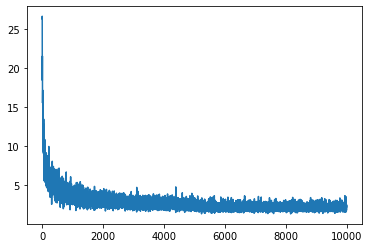

In [11]:
plt.plot(paso_i, perdidas_i);

Una función que nos permite obtener más fácilmente el valor actual de la función de pérdida, según queramos analizar uno u otro *split* —conjunto de datos—. Nuestra función estará precedida por un «decorador». En esencia, un decorador altera la función que precede (o que «decora»). En este caso, el decorador que utilizamos indica al programa que no debe rastrear los gradientes de nuestros parámetros. Así, nuestro programa fluye con mayor rapidez, puesto que disminuye su carga de trabajo.

In [12]:
@torch.no_grad() # decorador
def perdida_split(split):
  x,y = {'train': (Xtr, Ytr),
         'val': (Xdev, Ydev),
         'test': (Xte, Yte)}[split]
  emb = C[x]
  a = torch.tanh(emb.view(-1, emb_dim*block_size) @ H + d)
  logits = a @ U + b
  perdida = F.cross_entropy(logits, y)
  print(split, perdida.item())

perdida_split('train')
perdida_split('val')
perdida_split('test')

train 2.1176223754882812
val 2.1515469551086426
test 2.1483922004699707


### Inicialización de pesos y sesgos

Nuestra inicialización debería ser equivalente a $\frac{1}{27}$, puesto que cualquier carácter debería ser igualmente probable que los demás antes de entrenar la red. Sin embargo, nuestra pérdida inicial es muchísimo peor. Según nuestro razonamiento, más bien deberíamos esperar una pérdida de:

In [73]:
-torch.tensor(1/27.0).log() # negative log likelihood

tensor(3.2958)

Para ejemplificar lo que está pasando, veamos un ejemplo a menor escala con cuatro *logits*. Cuando obtenemos valores aleatorios, nuestra distribución de probabilidades es normal —debido al diseño de `torch.randn`— y nuestros valores son cercanos a cero, de manera que una función de pérdida iniciada con estos parámetros representa buenamente nuestro razonamiento anterior:

In [18]:
logits_ej = torch.randn(4)
probs_ej = torch.softmax(logits_ej, dim=0)
perdida_ej = -probs_ej[2].log()

logits_ej, probs_ej, perdida_ej

(tensor([-1.1220,  0.1112, -0.9848, -0.4849]),
 tensor([0.1339, 0.4595, 0.1535, 0.2531]),
 tensor(1.8738))

Ahora, ejemplifiquemos lo que realmente está pasando en nuestra red.

In [21]:
logits_ej = torch.randn(4) * 10 # multiplicamos por 10 los logits
probs_ej = torch.softmax(logits_ej, dim=0)
perdida_ej = -probs_ej[2].log()

logits_ej, probs_ej, perdida_ej

(tensor([ 17.4183, -17.6220,   4.1508,  17.9295]),
 tensor([3.7490e-01, 2.2704e-16, 6.4850e-07, 6.2510e-01]),
 tensor(14.2486))

Dado que nuestros *logits* ahora adquieren valores más extremos, la distribución se arruina puesto que divergen con mayor magnitud entre sí. Como resultado, la pérdida inicial es gigantesca. En esta misma línea, podemos inferir que nuestra pérdida mejoraría si disminuimos nuestros pesos en la inicialización, multiplicándolos por un número sumamente pequeño. Los sesgos, de la misma manera, tendrían que ser reducidos a cero inicialmente. La finalidad de todo esto es eficientar el proceso de aprendizaje de la red, puesto que de otra forma desperdiciaría los primeros cientos o miles de iteraciones intentando corregir estas divergencias en la distribución de probabilidades asignadas a las predicciones.

In [157]:
C = torch.randn(vocab_size, emb_dim) # tabla de consulta
H = torch.randn((emb_dim*block_size, h)) # pesos ocultos
d = torch.randn(h) # sesgos ocultos

U = torch.randn(h, vocab_size) * 0.01 # pesos de la segunda capa
b = torch.randn(vocab_size) * 0.0 # sesgos de la segunda capa

parametros = [C, H, d, U, b]
for p in parametros:
  p.requires_grad = True

In [158]:
max_steps = 10000 
batch_size = 32
paso_i = []
perdidas_i = []

for i in range(max_steps):
  #minibatch («minilote»)
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))

  # propagación hacia delante
  emb = C[Xtr[ix]]
  a = torch.tanh(emb.view(-1, emb_dim*block_size) @ H + d)
  logits = a @ U + b
  perdida = F.cross_entropy(logits, Ytr[ix])
  
  # propagación hacia atrás
  for p in parametros:
    p.grad = None
  perdida.backward()

  # actualización
  lr = 0.1 if i < 5000 else 0.01
  for p in parametros:
    p.data += -lr * p.grad

  # registrar estadísticas
  paso_i.append(i)
  perdidas_i.append(perdida.item())

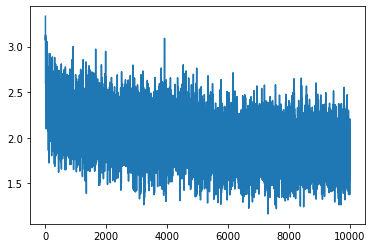

In [159]:
plt.plot(paso_i, perdidas_i);

In [160]:
perdida_split('train')
perdida_split('val')
perdida_split('test')

train 1.8836445808410645
val 1.9156681299209595
test 1.9303653240203857


Nuestro gráfico de la pérdida ahora luce diferente, y nuestra pérdida final es mejor debido a que no desperdiciamos etapas de entrenamiento.

### Propiedades de la tangente hiperbólica
En nuestra [primera lección]() sobre redes neuronales, implementamos el cálculo del gradiente de la tangente hiperbólica con la fórmula `(1 - t**2)`. Por otro lado, la tangente hiperbólica «aplasta» nuestros parámetros durante el entrenamiento, dejándolos en valores que van del 0 al 1. Si somos cuidadosos, notaremos que cuando hacemos propagación hacia atrás, nuestros parámetros que después de la tangente hiperbólica sean 1 o -1, tendrán un gradiente de 0 y, por tanto, no serán entrenados. Su «influencia» en el resultado de la red neuronal será también 0.

Ahora, procuraremos cuidar que nuestra red no padezca de este problema. Analicemos, por ejemplo, cómo están distribuidos nuestros parámetros después de aplicarles la tangente hiperbólica (esta es nuestra variable `a`):

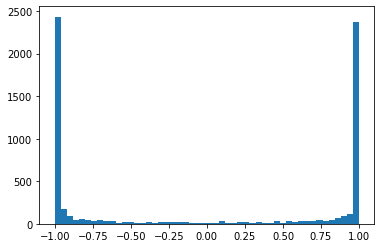

In [161]:
plt.hist(a.view(-1).tolist(), 50);

Por otra parte, estos son nuestros valores antes de pasar por `tanh`:

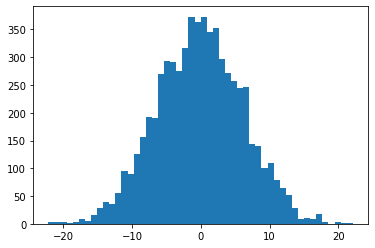

In [162]:
plt.hist((emb.view(-1, emb_dim*block_size) @ H + d).view(-1).tolist(), 50);

Podemos ver que nuestros valores tienen valores extremos que, en consecuencia, terminan en las «colas» (*tails*) de la tangente hiperbólica, es decir, con valores de -1 y 1. Para visualizar esto de mejor manera, pongamos que todos los valores que sean -1 y 1 sean blancos, y negros si tienen cualquier otro valor:

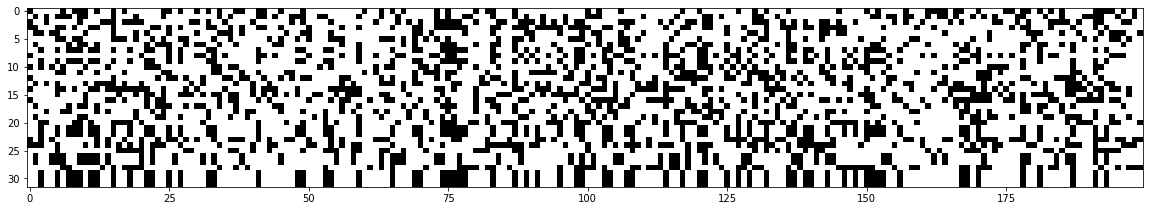

In [163]:
plt.figure(figsize=(20,10))
plt.imshow(a.abs() > 0.99, cmap='gray', interpolation='nearest')

Hay una cantidad ingente de blancos y esto es una mala señal, puesto que implica que muchos de nuestros parámetros no están aprendiendo nada. La solución es idéntica a nuestro ejercicio anterior: si evitamos valores extremos, minimizando los valores iniciales de los parámetros y sesgos de la primera capa, entonces deberíamos obtener una mejor y más compacta distribución de valores, evitando así valores extremos y mejorando el entrenamiento. Comprobémoslo:

In [172]:
C = torch.randn(vocab_size, emb_dim) # tabla de consulta
H = torch.randn((emb_dim*block_size, h)) * 0.3 # pesos ocultos
d = torch.randn(h) * 0.01 # sesgos ocultos
U = torch.randn(h, vocab_size) * 0.01 # pesos de la segunda capa
b = torch.randn(vocab_size) * 0.0

parametros = [C, H, d, U, b]
for p in parametros:
  p.requires_grad = True

In [173]:
for i in range(max_steps):
  #minibatch («minilote»)
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))

  # propagación hacia delante
  emb = C[Xtr[ix]]
  a = torch.tanh(emb.view(-1, emb_dim*block_size) @ H + d)
  logits = a @ U + b
  perdida = F.cross_entropy(logits, Ytr[ix])
  
  # propagación hacia atrás
  for p in parametros:
    p.grad = None
  perdida.backward()

  # actualización
  lr = 0.1 if i < 5000 else 0.01
  for p in parametros:
    p.data += -lr * p.grad

In [174]:
perdida_split('train')
perdida_split('val')
perdida_split('test')

train 1.867079734802246
val 1.8933453559875488
test 1.916183590888977


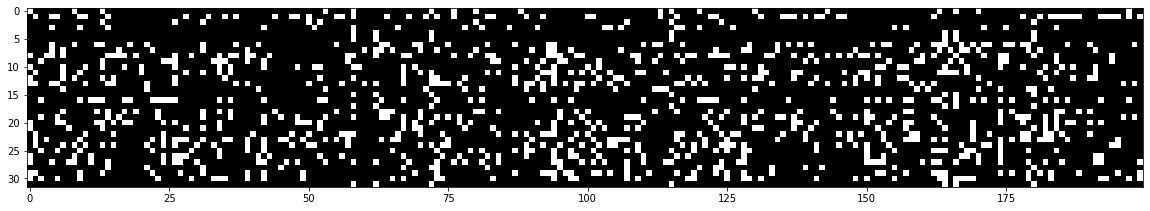

In [175]:
plt.figure(figsize=(20,10))
plt.imshow(a.abs() > 0.99, cmap='gray', interpolation='nearest')

Ahora nuestra pérdida mejoró y predomina el negro —valores distintos de -1 y 1— en nuestra red.

### Inicialización Kaiming
La generalización y formalización de nuestro razonamiento fue llevada a cabo por Kaiming He en un [*paper* del 2015](https://arxiv.org/abs/1502.01852). Análisis matemáticos mediante, descubrió que cuando utilizamos la tangente hiperbólica, nuestros pesos iniciales deben estar escalados por la fórmula $\frac{\frac{5}{3}}{\sqrt{\text{fan-in}}}$, donde *fan-in* —una expresión tomada de los circuitos eléctricos— es el número de *inputs* que toman nuestros pesos (en nuestro caso, `emb_dim*block_size`). Por tanto, nuestra inicialización debería estar escalada por $\frac{\frac{5}{3}}{\sqrt{\text{fan-in}}} = \frac{\frac{5}{3}}{\sqrt{\text{emb_dim x block_size}}} = \frac{\frac{5}{3}}{\sqrt{30}}$:

In [184]:
(5/3) / 30**0.5 # elevar a 0.5 es equivalente a obtener la raíz cuadrada

0.3042903097250923

Y obtenemos el valor que habíamos utilizado. La intuición detrás de esto es que, como decíamos, queremos minimizar los parámetros en la inicialización, y queremos también que tengan una distribución normal (gaussiana). Para conseguirlo, debemos multiplicar nuestros pesos iniciales por un número pequeño; pero para que la distribución consiga normalidad, este número pequeño debe tener ciertas cualidades —precisamente, las que la fórmula obtiene. 

Ejemplifiquemos: supongamos que `x` es nuestro *input* y `w` nuestra matriz de pesos. Al multiplicarlos entre sí —como hacemos en una red neuronal—, nuestra distribución cambia, aumentando la desviación estándar —la extensión de los valores—:

tensor(-0.0004) tensor(1.0086)
tensor(-0.0133) tensor(3.1457)


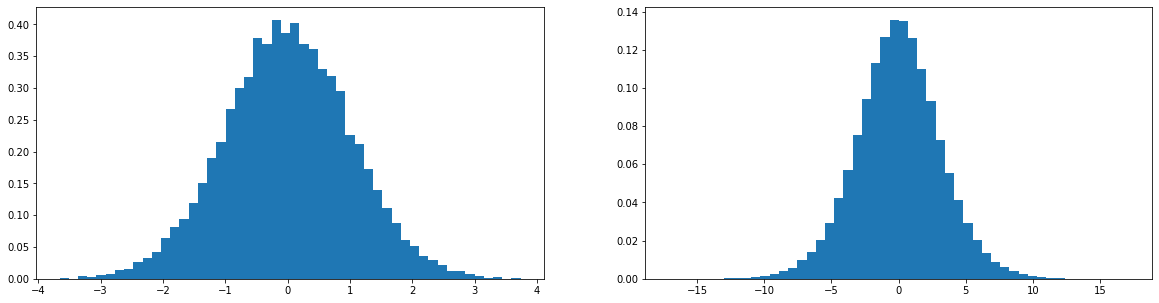

In [188]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200)
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

Si al inicio los valores de `x` iban del -4 al 4, tras ser multiplicados por `w` ahora van del -15 al 15. Hay valores más alejados del centro de la distribución que antes, por lo que la desviación estándar es más alta. Recordemos que esto arruinaba la tangente hiperbólica. Pero si minimizamos los valores de `w`, al multiplicarlos por `x` la distribución no se expanderá. Todavía mejor: podemos minimizar los valores de `w` de tal forma que `x` mantenga exactamente la misma distribución. Para ello utilizamos las fórmulas de Kaiming He. En este ejemplo, dado que solo multiplicamos y no usamos `tanh`, la fórmula es $\frac{1}{\sqrt{\text{fan-in}}}$:

tensor(-0.0165) tensor(0.9966)
tensor(-0.0028) tensor(0.9878)


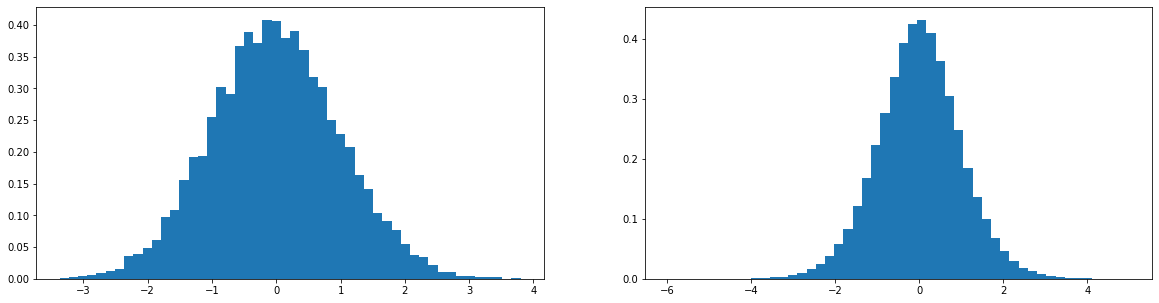

In [191]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200) * 1 / 10**0.5
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

Aunque los valores cambiaran, la desviación estándar permanece igual. 

### Normalización por lotes (*batch normalization*)
Una técnica que cumple la misma función, pero que se utiliza más ampliamente por sus propiedades, es la llamada [«normalización por lotes»](https://arxiv.org/abs/1502.03167). En esencia, podemos prescindir de las fórmulas de Kaiming He y generalizar todavía más su solución. Para ello, normalizamos directamente la distribución de valores de cada matriz de pesos. El algoritmo luce así:

$$
\begin{array}{rlr|}
\hline \text { Input: } & \text { Values of } x \text { over a mini-batch: } \mathcal{B}=\left\{x_{1 \ldots m}\right\}  \\
& \text { Parameters to be learned: } \gamma, \beta \\
\text { Output: } & \left\{y_i=\mathrm{BN}_{\gamma, \beta}\left(x_i\right)\right\} & \\
\mu_{\mathcal{B}} & \leftarrow \frac{1}{m} \sum_{i=1}^m x_i & / / \text { mini-batch mean } \\
\sigma_{\mathcal{B}}^2 & \leftarrow \frac{1}{m} \sum_{i=1}^m\left(x_i-\mu_{\mathcal{B}}\right)^2 & / / \text { mini-batch variance } \\
\widehat{x}_i & \leftarrow \frac{x_i-\mu_{\mathcal{B}}}{\sqrt{\sigma_{\mathcal{B}}^2+\epsilon}} & \quad / / \text { normalize } \\
y_i & \leftarrow \gamma \widehat{x}_i+\beta \equiv \operatorname{BN}_{\gamma, \beta}\left(x_i\right) & / / \text { scale and shift }
\end{array}
$$

Y aunque parezca complicado, la implementación programática es bastante sencilla:

In [40]:
C = torch.randn(vocab_size, emb_dim) # tabla de consulta
H = torch.randn((emb_dim*block_size, h)) * 0.3 # pesos ocultos
#d = torch.randn(h) * 0.01 # sesgos ocultos
U = torch.randn(h, vocab_size) * 0.01 # pesos de la segunda capa
b = torch.randn(vocab_size) * 0.0

bngain = torch.ones((1, h)) # gamma
bnbias = torch.zeros((1, h)) # beta
bnmean_running = torch.zeros((1, h))
bnstd_running = torch.ones((1, h))

parametros = [C, H, U, b, bngain, bnbias]
for p in parametros:
  p.requires_grad = True

In [41]:
for i in range(max_steps):
  #minibatch («minilote»)
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))

  # propagación hacia delante
  emb = C[Xtr[ix]]
  pre_a = emb.view(-1, emb_dim*block_size) @ H #+ d
  # BatchNorm
  # -----
  bnmean_i = pre_a.mean(0, keepdim=True)
  bnstd_i =  pre_a.std(0, keepdim=True)
  pre_a = bngain * (pre_a - bnmean_i) / bnstd_i + bnbias
  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmean_i
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstd_i 
  # -----
  a = torch.tanh(pre_a)
  logits = a @ U + b
  perdida = F.cross_entropy(logits, Ytr[ix])
  
  # propagación hacia atrás
  for p in parametros:
    p.grad = None
  perdida.backward()

  # actualización
  lr = 0.1 if i < 5000 else 0.01
  for p in parametros:
    p.data += -lr * p.grad

In [42]:
@torch.no_grad() # decorador
def perdida_split(split):
  x,y = {'train': (Xtr, Ytr),
         'val': (Xdev, Ydev),
         'test': (Xte, Yte)}[split]
  emb = C[x]
  pre_a = emb.view(-1, emb_dim*block_size) @ H + d
  pre_a = bngain * (pre_a - bnmean_running) / bnstd_running + bnbias
  a = torch.tanh(pre_a)
  logits = a @ U + b
  perdida = F.cross_entropy(logits, y)
  print(split, perdida.item())

perdida_split('train')
perdida_split('val')
perdida_split('test')

train 1.9545596837997437
val 1.9609586000442505
test 1.9600375890731812


### PyTorch



In [62]:
class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

In [63]:
emb_dim = 10 # cada embedding tendrá 10 dimensiones
block_size = 3
h = 200 # cada capa tendrá 200 unidades (hidden units)
vocab_size = len(fap) #tamaño del vocabulario

C = torch.randn(vocab_size, emb_dim) # tabla de consulta
layers = [
    Linear(emb_dim * block_size, h, bias=False), BatchNorm1d(h), Tanh(),
    Linear(h, h, bias=False), BatchNorm1d(h), Tanh(),
    Linear(h, h, bias=False), BatchNorm1d(h), Tanh(),
    Linear(h, vocab_size, bias=False), BatchNorm1d(vocab_size),
]

with torch.no_grad():
  layers[-1].gamma *= 0.1
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 1.0

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
  p.requires_grad = True

92924


In [64]:
perdida_i = []
ud = []
max_steps = 10000

for i in range(max_steps):
  #minibatch («minilote»)
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))

  # propagación hacia delante
  emb = C[Xtr[ix]]
  x = emb.view(emb.shape[0], -1)
  for layer in layers:
    x = layer(x)
  perdida = F.cross_entropy(x, Ytr[ix])
  
  # propagación hacia atrás
  for layer in layers:
    layer.out.retain_grad()
  for p in parameters:
    p.grad = None
  perdida.backward()

  # actualización
  lr = 0.1 if i < 5000 else 0.01
  for p in parametros:
    p.data += -lr * p.grad

  # estadísticas
  if i % 1000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {perdida.item():.4f}')
  perdidas_i.append(perdida.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

      0/  10000: 3.3156
   1000/  10000: 3.2813
   2000/  10000: 3.2792
   3000/  10000: 3.3146
   4000/  10000: 3.3071
   5000/  10000: 3.2983
   6000/  10000: 3.2956
   7000/  10000: 3.2848
   8000/  10000: 3.2666
   9000/  10000: 3.3004


In [36]:
block_size = 3
for _ in range(20):
  out = []
  context = [0] * block_size
  while True:
    emb = C[torch.tensor([context])]
    a = torch.tanh(emb.view(1, -1) @ H + d)
    logits = a @ U + b
    probs = F.softmax(logits, dim=1)
    ix = torch.multinomial(probs, num_samples=1).item()
    context = context[1:] + [ix]
    out.append(ix)
    if ix == 0:
      break

  print(''.join(fap[i] for i in out))

rulio.
maria.
homerigjovina.
aso.
lilandioleda.
jer.
valdinza.
sumenda.
ener.
neleudotgimio.
idelermovelina.
delma.
elzy.
balbertorancio.
casikufinechuio.
ber.
helola.
pino.
moriana.
alberijonelicio.
